TODO: make an embedding space that is 3D and plot it

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# create dataset
block_size = 3  # how many chars of context to predict next one

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size  # 0 is '.' in itos
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)   # input is context
            Y.append(ix)    # predict next char
            context = context[1:] + [ix]    # shift context
            
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape) # (number of samples, block size)
    return X,Y

In [5]:
# train dev test split
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
# create MLP with 2 hidden layers
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator=g) # map 27-D->10-D embedding space; different from one-hot because these params are also optimized for to cluster semantically similar chars together
W1 = torch.randn((30,200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200,27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C,W1,b1,W2,b2]
sum(p.nelement() for p in parameters)   # num of params total

11897

In [18]:
print(Xtr[([0, 3])])   # see embeddings for the 0th and 3rd training sample
emb = C[Xtr[([0, 3])]]
print(emb.shape)
emb

tensor([[ 0,  0,  0],
        [25, 21,  8]])
torch.Size([2, 3, 10])


tensor([[[ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296, -1.5471,
           0.6049,  0.0791,  0.9046],
         [ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296, -1.5471,
           0.6049,  0.0791,  0.9046],
         [ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296, -1.5471,
           0.6049,  0.0791,  0.9046]],

        [[-1.2801,  0.0924,  0.1053, -0.3907,  0.0317, -0.5475,  0.8183,
          -0.8163, -0.3924, -0.7452],
         [-0.2478,  0.8828, -0.0810, -0.9530, -0.4884, -0.7371,  0.7061,
          -0.1930,  1.2348,  0.3331],
         [-1.1641,  1.2473, -0.2706, -1.3635,  1.3066,  0.3231,  1.0358,
          -0.8625, -1.2575,  0.9418]]], grad_fn=<IndexBackward0>)

In [21]:
for p in parameters: p.requires_grad=True
lri, lossi, stepi = ([] for i in range(3))

In [22]:
# training cycle
for i in range(200000):
    ix = torch.randint(0, Xtr.shape[0], (32,))  # minibatch size of 32
    
    # forward pass
    emb = C[Xtr[ix]]    # (32, 3, 10); get embeddings for each sample in minibatch
    h = torch.tanh(emb.view(-1,30) @ W1 + b1)   # (32, 30) @ (30, 200) = (32, 200); will squash all 3 letters in block together as one training sample
    logits = h @ W2 + b2    # (32, 27); convert back to alphabet
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # grad update
    lr = 0.1 if i < 100000 else 0.01    # learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # learning curve
    stepi.append(i)
    lossi.append(loss.log10().item())

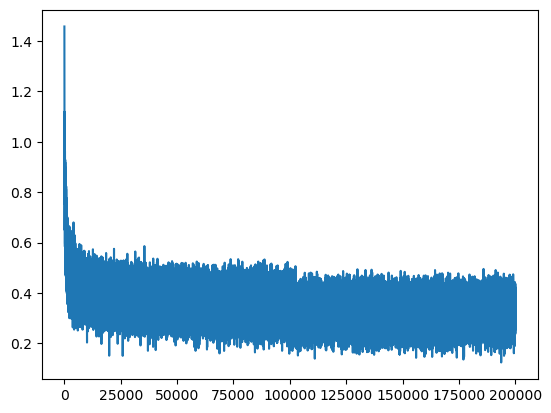

In [23]:
plt.plot(stepi, lossi)

In [25]:
# training loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)   # (32, 200)
logits = h @ W2 + b2
train_loss = F.cross_entropy(logits, Ytr)
print(f"{train_loss: }")

# validation loss

emb = C[Xdev]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)   # (32, 200)
logits = h @ W2 + b2
dev_loss = F.cross_entropy(logits, Ydev)
print(f"{dev_loss: }")

# test loss

emb = C[Xte]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)   # (32, 200)
logits = h @ W2 + b2
test_loss = F.cross_entropy(logits, Yte)
print(f"{test_loss: }")


 2.136911630630493
 2.1736183166503906
 2.1730170249938965


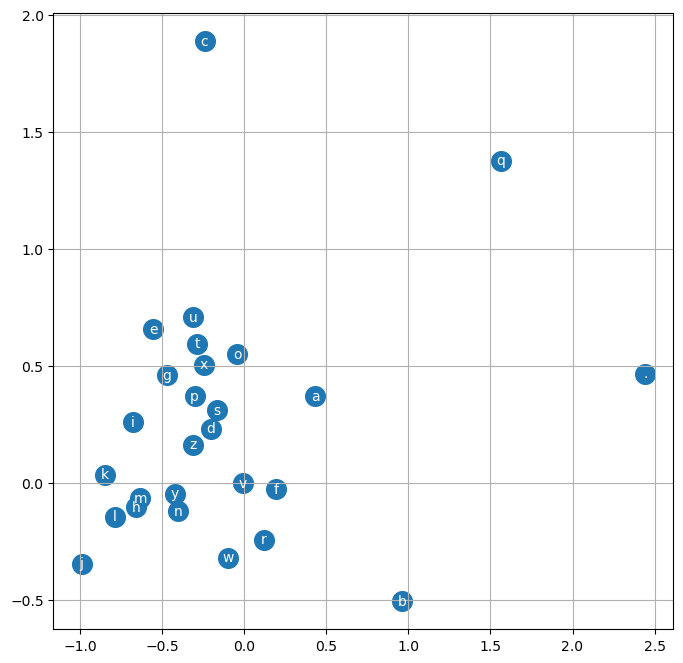

In [27]:
# visualize embedding matrix C when it is 2 dim
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)    # get first and second dimensions of each char
for i in range(C.shape[0]): # C is (27, 10); for each letter in alphabet
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [159]:
# sample from model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(5):
    out = []
    context = [0] * block_size # start with ...
    while True:
        emb = C[torch.tensor([context])]    # (1, 3, 10)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)   # (3, 10)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

carlah.
amelle.
khi.
mili.
thal.


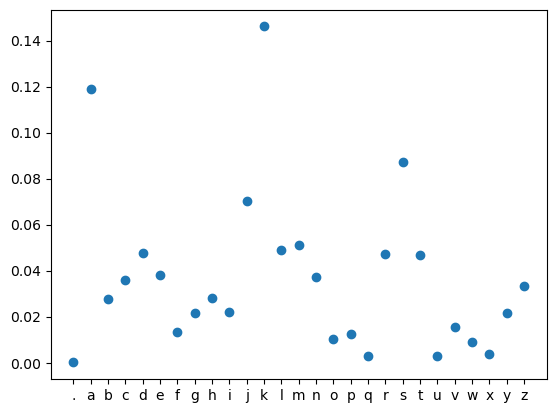

In [66]:
# curious about what letters are likely to come first
emb = C[torch.tensor([0,0,0])]    # (1, 3, 10)
h = torch.tanh(emb.view(1, -1) @ W1 + b1)   # (3, 10)
logits = h @ W2 + b2
probs = F.softmax(logits, dim=1)

ys = probs.tolist()[0]
xs = [itos[i] for i,_ in enumerate(ys)]

plt.scatter(xs, ys)

## Exercises

- E01: Tune the hyperparameters of the training to beat my best validation loss of 2.2

Tunable params: lr, neurons in hidden layer W, dim in embedding (could also do epochs or minibatch size)

In [131]:
# define hyperparams

lre = torch.linspace(-3, 0, 10)
lrs = 10**lre
print(lrs)

neurons = torch.linspace(50, 500, 10, dtype=int)
print(neurons)

dims = torch.linspace(2, 20, 10, dtype=int)
print(dims)

tensor([0.0010, 0.0022, 0.0046, 0.0100, 0.0215, 0.0464, 0.1000, 0.2154, 0.4642,
        1.0000])
tensor([ 50, 100, 150, 200, 250, 300, 350, 400, 450, 500])
tensor([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20])


In [102]:
import numpy as np
results_mat = np.zeros((10,10,10))

In [126]:
# grid search

for i,lr in enumerate(lrs):
    for j,n in enumerate(neurons):
        for k,dim in enumerate(dims):
            C = torch.randn((27,dim), generator=g)
            W1 = torch.randn((dim*3,n), generator=g)
            b1 = torch.randn(n, generator=g)
            W2 = torch.randn((n,27), generator=g)
            b2 = torch.randn(27, generator=g)

            parameters = [C,W1,b1,W2,b2]
            
            for p in parameters: p.requires_grad=True
            
            # training cycle
            for _ in range(2000):
                ix = torch.randint(0, Xtr.shape[0], (32,))  # minibatch size of 32
                
                # forward pass
                emb = C[Xtr[ix]]    # (32, 3, 10); get embeddings for each sample in minibatch
                h = torch.tanh(emb.view(-1,dim*3) @ W1 + b1)   # (32, 30) @ (30, 200) = (32, 200); will squash all 3 letters in block together as one training sample
                logits = h @ W2 + b2    # (32, 27); convert back to alphabet
                loss = F.cross_entropy(logits, Ytr[ix])
                
                # backward pass
                for p in parameters:
                    p.grad = None
                loss.backward()
                
                # grad update
                for p in parameters:
                    p.data += -lr * p.grad

            # validation loss

            emb = C[Xdev]
            h = torch.tanh(emb.view(-1,dim*3) @ W1 + b1)   # (32, 200)
            logits = h @ W2 + b2
            dev_loss = F.cross_entropy(logits, Ydev)

            results_mat[i][j][k] = dev_loss.item()

In [127]:
# find best settings
idx = np.unravel_index(np.argmin(results_mat), results_mat.shape)
print(idx)
print(results_mat[idx])
print(lrs[idx[0]], neurons[idx[1]], dims[idx[2]])

(7, 0, 1)
2.500591516494751
tensor(0.2154) tensor(50) tensor(4)


In [138]:
# training cycle

lr = 0.2154
n = 50
dim = 4

C = torch.randn((27,dim), generator=g)
W1 = torch.randn((dim*3,n), generator=g)
b1 = torch.randn(n, generator=g)
W2 = torch.randn((n,27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C,W1,b1,W2,b2]

for p in parameters: p.requires_grad=True

for i in range(200000):
    ix = torch.randint(0, Xtr.shape[0], (32,))  # minibatch size of 32
    
    # forward pass
    emb = C[Xtr[ix]]    # (32, 3, 10); get embeddings for each sample in minibatch
    h = torch.tanh(emb.view(-1,3*dim) @ W1 + b1)   # (32, 30) @ (30, 200) = (32, 200); will squash all 3 letters in block together as one training sample
    logits = h @ W2 + b2    # (32, 27); convert back to alphabet
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # grad update
    for p in parameters:
        p.data += -lr * p.grad

In [139]:
# training loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1,3*dim) @ W1 + b1)   # (32, 200)
logits = h @ W2 + b2
train_loss = F.cross_entropy(logits, Ytr)
print(f"{train_loss: }")

# validation loss

emb = C[Xdev]
h = torch.tanh(emb.view(-1,3*dim) @ W1 + b1)   # (32, 200)
logits = h @ W2 + b2
dev_loss = F.cross_entropy(logits, Ydev)
print(f"{dev_loss: }")

# test loss

emb = C[Xte]
h = torch.tanh(emb.view(-1,3*dim) @ W1 + b1)   # (32, 200)
logits = h @ W2 + b2
test_loss = F.cross_entropy(logits, Yte)
print(f"{test_loss: }")


 2.2517855167388916
 2.264915943145752
 2.264674186706543


- E02: I was not careful with the intialization of the network in this video. (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?

1) Default is all the embeddings and weights the same
2) Starting initialization of weights should be random but divided by stdev

In [155]:
# create MLP with 2 hidden layers
g = torch.Generator().manual_seed(2147483647)
C = torch.rand((27,10), generator=g) # rand is uniform distribution instead of randn
W1 = torch.rand((30,200), generator=g)
b1 = torch.rand(200, generator=g)
W2 = torch.rand((200,27), generator=g)
b2 = torch.rand(27, generator=g)

parameters = [C,W1,b1,W2,b2]
sum(p.nelement() for p in parameters)   # num of params total

for p in parameters: p.requires_grad=True

In [156]:
# training cycle
for i in range(200000):
    ix = torch.randint(0, Xtr.shape[0], (32,))  # minibatch size of 32
    
    # forward pass
    emb = C[Xtr[ix]]    # (32, 3, 10); get embeddings for each sample in minibatch
    h = torch.tanh(emb.view(-1,30) @ W1 + b1)   # (32, 30) @ (30, 200) = (32, 200); will squash all 3 letters in block together as one training sample
    logits = h @ W2 + b2    # (32, 27); convert back to alphabet
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # grad update
    lr = 0.1 if i < 100000 else 0.01    # learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # learning curve
    stepi.append(i)
    lossi.append(loss.log10().item())

In [158]:
# training loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)   # (32, 200)
logits = h @ W2 + b2
train_loss = F.cross_entropy(logits, Ytr)
print(f"{train_loss: }")

# validation loss

emb = C[Xdev]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)   # (32, 200)
logits = h @ W2 + b2
dev_loss = F.cross_entropy(logits, Ydev)
print(f"{dev_loss: }")

# test loss

emb = C[Xte]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)   # (32, 200)
logits = h @ W2 + b2
test_loss = F.cross_entropy(logits, Yte)
print(f"{test_loss: }")


 2.0713155269622803
 2.1191556453704834
 2.117372751235962


### CORRRECTION

What he did was calculate the expected loss if it was all the probabilities were the same. A uniform distribution is achieved if all predicted probabilities are the same, which is the same as all logits being equal (ex. all 0). So he saw that the logits = h@W2+b2 can be all 0 if you initialize by multiplying b2 by 0 and make W2 very small. We don't want to make W2 0 because then it can hurt its learning.

In [4]:
-torch.tensor(1/27.0).log() # one that is supposed to be right is predicted with probability 1/27

tensor(3.2958)

- E03: Read the Bengio et al 2003 paper (link above), implement and try any idea from the paper. Did it work?

Main difference between n-gram and MLP model: n-gram builds a huge lookup table which captures all the precise probabilities of next letter, whereas in the MLP model we use 2 layers for encoding into a feature space and then transforming that feature space inputs via a tanh hidden layer to approximate a probability.